# Predict NMR Outcomes
  Now that we have predicted whether or not their are NMR outcomes, we can predict what precisely they are.

  For this, we need to use multi-label classifiers

  Sources: <https://scikit-learn.org/stable/modules/multiclass.html#multilabel-classification>

# Prepare the Data

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
!pip install category_encoders
from category_encoders import LeaveOneOutEncoder

import seaborn as sns

from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

     |████████████████████████████████| 80 kB 3.9 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#select only columns applicable to classifier
use_col = ['Gender', 'Race', 'Ethnicity', 'Age_at_Crime',
            'Age_at_Arrest', 'Court_ORI',
            'Judge_Name', 'Arrest_Type', 'Offense_Date',
            'Top_Charge_Severity_at_Arrest', 'Top_Charge_Weight_at_Arrest',
            'Top_Charge_at_Arrest_Violent_Felony_Ind', 'Arraign Charge Category',
            'Representation_Type', 'prior_vfo_cnt', 
            'prior_nonvfo_cnt', 'prior_misd_cnt',
            'supervision', 'NMR_at_Arraign', 'Pretrial_Supervision_at_Arraign',
            'Contact_Pretrial_Service_Agency',
            'Electronic_Monitoring', 'Travel_Restrictions',
            'Passport_Surrender','No_Firearms_or_Weapons',
            'Maintain_Employment', 'Maintain_Housing',
            'Maintain_School', 'Placement_in_Mandatory_Program',
            'Removal_to_Hospital', 'Obey_Order_of_Protection',
            'Obey_Court_Conditions-Family_Offense', 'Other_NMR']
#This is for when we want to make x, y sets
pred_cols = ['NMR_at_Arraign', 'Pretrial_Supervision_at_Arraign',
             'Contact_Pretrial_Service_Agency',
             'Electronic_Monitoring', 'Travel_Restrictions',
             'Passport_Surrender','No_Firearms_or_Weapons',
             'Maintain_Employment', 'Maintain_Housing',
             'Maintain_School', 'Placement_in_Mandatory_Program',
             'Removal_to_Hospital', 'Obey_Order_of_Protection',
             'Obey_Court_Conditions-Family_Offense', 'Other_NMR']
#Load Data
df = pd.read_pickle("clean_df.pkl")
df = df.filter(use_col)

#Filter rows so we are only looking at 2018 to present years
df = df[pd.DatetimeIndex(df['Offense_Date']).year >= 2018 ].reset_index(drop = True)

#create df where no nan in NMF column
df = df[df['NMR_at_Arraign'].notna()]

In [3]:
#Tidy the data so that it is complete

#Change nan to 'Unkown' in categorical data
categories_list = ['Gender', 'Race', 'Ethnicity',
                   'Judge_Name', 'Top_Charge_Severity_at_Arrest', 'Top_Charge_Weight_at_Arrest',
                   'Top_Charge_at_Arrest_Violent_Felony_Ind', 'Arraign Charge Category',
                   'Representation_Type' ]
#In the categorical data change the nan values to 'Unknown'
df[categories_list] = df[categories_list].fillna('Unknown')

#Replace Age_at_Crime and Age_at_Arrest with median
crime_age_median = df['Age_at_Crime'].median()
arrest_age_median = df['Age_at_Arrest'].median()
df['Age_at_Crime'].fillna(crime_age_median, inplace = True)
df['Age_at_Arrest'].fillna(arrest_age_median, inplace = True)

#Replace nan with a random value with correct weighted probability (to match the population)
vfo_choices = [0.0, 1.0, 2.0]
df['prior_vfo_cnt'] = df['prior_vfo_cnt'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(vfo_choices, p=[0.84, 0.13, 0.03])))
nonvfo_choices = [0.0, 1.0, 2.0, 3.0, 4.0]
df['prior_nonvfo_cnt'] = df['prior_nonvfo_cnt'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(nonvfo_choices, 1, p=[0.74, 0.14, 0.06, 0.03, 0.03])))
misd_choices = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 1.0]
df['prior_misd_cnt'] = df['prior_misd_cnt'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(misd_choices, 1, p=[0.54, 0.13, 0.08, 0.07, 0.05, 0.04, 0.03, 0.02, 0.02, 0.01, 0.01])))
supervision_choices = [0.0, 1.0]
df['supervision'] = df['supervision'].apply(lambda l: l if not np.isnan(l) else float(np.random.choice(supervision_choices, 1, p=[0.91, 0.09])))

#For NMR_at_Arraign and below change N to 0.0 and Y to 1.0
binary_list = ['Top_Charge_at_Arrest_Violent_Felony_Ind','NMR_at_Arraign', 'Pretrial_Supervision_at_Arraign', 'Contact_Pretrial_Service_Agency',
               'Electronic_Monitoring', 'Travel_Restrictions', 'Passport_Surrender', 'No_Firearms_or_Weapons',
               'Maintain_Employment', 'Maintain_Housing', 'Maintain_School', 'Placement_in_Mandatory_Program',
               'Removal_to_Hospital', 'Obey_Order_of_Protection', 'Obey_Court_Conditions-Family_Offense', 'Other_NMR']

for i in binary_list:
  df[i] = df[i].map({'Y': 1.0 ,'N': 0.0})

#Make the age into age groups for both age at crime and age at arrest
df.loc[df['Age_at_Crime'] <= 17, 'age_group_crime'] = 0
df.loc[df['Age_at_Crime'].between(17,24, inclusive = True), 'age_group_crime'] = 1
df.loc[df['Age_at_Crime'].between(25,34, inclusive = True), 'age_group_crime'] = 2
df.loc[df['Age_at_Crime'].between(35,44, inclusive = True), 'age_group_crime'] = 3
df.loc[df['Age_at_Crime'].between(45,54, inclusive = True), 'age_group_crime'] = 4
df.loc[df['Age_at_Crime'].between(55,64, inclusive = True), 'age_group_crime'] = 5
df.loc[df['Age_at_Crime'] >= 65, 'age_group_crime'] = 6

df.loc[df['Age_at_Arrest'] <= 17, 'age_group_arrest'] = 0
df.loc[df['Age_at_Arrest'].between(17,24, inclusive = True), 'age_group_arrest'] = 1
df.loc[df['Age_at_Arrest'].between(25,34, inclusive = True), 'age_group_arrest'] = 2
df.loc[df['Age_at_Arrest'].between(35,44, inclusive = True), 'age_group_arrest'] = 3
df.loc[df['Age_at_Arrest'].between(45,54, inclusive = True), 'age_group_arrest'] = 4
df.loc[df['Age_at_Arrest'].between(55,64, inclusive = True), 'age_group_arrest'] = 5
df.loc[df['Age_at_Arrest'] >= 65, 'age_group_arrest'] = 6

df['Court_ORI'].unique()
##Remove Letters from Court ORI because they are consistent in each
df['Court_ORI'] = df["Court_ORI"].str.replace("[NYJ]","")
#Convert Court ORI from string to int
df['Court_ORI'] = [int(i) for i in df['Court_ORI']]

#Make arrest type binary 'DAT' = 1, 'Custody' = 0
df['Arrest_Type'] = df['Arrest_Type'].map({'DAT': 1.0 ,'Custody': 0.0})

#For Top Charge Severity at Arrest Change them into integers based on severity
#0- Unknown, 1-Violation, 2-Infraction, 3-Misdemeanor, 4-Felony
df['Top_Charge_Severity_at_Arrest'] = df["Top_Charge_Severity_at_Arrest"].replace("Unknown","0.0")
df['Top_Charge_Severity_at_Arrest'] = df["Top_Charge_Severity_at_Arrest"].replace("Violation","1.0")
df['Top_Charge_Severity_at_Arrest'] = df["Top_Charge_Severity_at_Arrest"].replace("Infraction","2.0")
df['Top_Charge_Severity_at_Arrest'] = df["Top_Charge_Severity_at_Arrest"].replace("Misdemeanor","3.0")
df['Top_Charge_Severity_at_Arrest'] = df["Top_Charge_Severity_at_Arrest"].replace("Felony","4.0")

#For Top Charge Weight at Arrest give integers weights based on severity
#0-Unknown, 1-V, 2-I, 3-UM, 4-BM, 5-AM, 6-EF, 7-DF, 8-CF, 9-BF, 10-AF
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("Unknown", 0.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("V", 1.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("I", 2.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("UM", 3.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("BM", 4.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("AM", 5.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("EF", 6.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("DF", 7.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("CF", 8.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("BF", 9.0)
df['Top_Charge_Weight_at_Arrest'] = df["Top_Charge_Weight_at_Arrest"].replace("AF", 10.0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavou

In [13]:
pred_col = []
pred_1_count = []
for x in pred_cols:
  print(x)
  y = df[x].value_counts()[1]
  print(df[x].value_counts()[1])
  pred_col.append(x)
  pred_1_count.append(y)

del pred_col[0]
del pred_1_count[0]

NMR_at_Arraign
26546
Pretrial_Supervision_at_Arraign
11628
Contact_Pretrial_Service_Agency
13678
Electronic_Monitoring
1447
Travel_Restrictions
335
Passport_Surrender
32
No_Firearms_or_Weapons
1685
Maintain_Employment
21
Maintain_Housing
7
Maintain_School
3
Placement_in_Mandatory_Program
17
Removal_to_Hospital
7
Obey_Order_of_Protection
204
Obey_Court_Conditions-Family_Offense
15
Other_NMR
4174


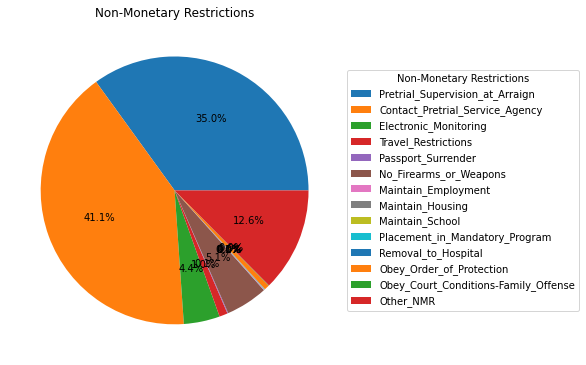

In [23]:
fig = plt.figure()
fig.set_figheight(20)
plt.pie(pred_1_count, autopct="%1.1f%%")
plt.title("Non-Monetary Restrictions")

plt.figsize=(10, 10)

plt.legend(pred_col,
          title="Non-Monetary Restrictions",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [ ]:
#Separate to features and labels
df_clean = df.drop(['Age_at_Crime', 'Age_at_Arrest', 'Offense_Date'], axis = 1)
features = df_clean.drop(pred_cols, axis = 1)
labels = df['NMR_at_Arraign'].copy()

In [ ]:
#Transform Categorical data Numerical 

#For columns with 10 categories or less, OneHotEncode
ohe_categories = ['Gender', 'Race', 'Ethnicity']

features = pd.get_dummies(features, columns = ohe_categories)

In [ ]:
#For columns with too many categories apply leave one out encoder
enc = LeaveOneOutEncoder(cols=['Judge_Name', 'Representation_Type', 'Arraign Charge Category'])
features =  enc.fit_transform(features, labels)
features.head()

,Court_ORI,Judge_Name,Arrest_Type,Top_Charge_Severity_at_Arrest,Top_Charge_Weight_at_Arrest,Top_Charge_at_Arrest_Violent_Felony_Ind,Arraign Charge Category,Representation_Type,prior_vfo_cnt,prior_nonvfo_cnt,prior_misd_cnt,supervision,age_group_crime,age_group_arrest,Gender_Female,Gender_Male,Gender_Unknown,Race_American Indian/Alaskan Native,Race_Asian/Pacific Islander,Race_Black,Race_Other,Race_Unknown,Race_White,Ethnicity_Hispanic,Ethnicity_Non Hispanic,Ethnicity_Unknown
0,30033,0.150000,1.0,3.0,5.0,0.0,0.092990,0.089994,0.0,0.0,0.0,0.0,3.0,3.0,0,1,0,0,0,1,0,0,0,0,1,0
1,30033,0.141361,0.0,3.0,5.0,0.0,0.111830,0.111493,0.0,1.0,10.0,0.0,3.0,3.0,0,1,0,0,0,0,0,0,1,0,1,0
2,29013,0.025061,1.0,3.0,5.0,0.0,0.117247,0.035369,0.0,0.0,0.0,0.0,1.0,1.0,0,1,0,0,0,0,0,0,1,0,1,0
3,14011,0.007955,1.0,3.0,5.0,0.0,0.117247,0.089994,0.0,0.0,0.0,0.0,1.0,1.0,0,1,0,0,0,0,0,0,1,0,1,0
4,14011,0.001621,1.0,3.0,3.0,0.0,0.019769,0.089994,0.0,1.0,0.0,0.0,3.0,3.0,0,1,0,0,0,0,0,1,0,0,0,1


In [ ]:
#Feature Scaling

scaler = StandardScaler()

features_scaled = scaler.fit_transform(features)
features_scaled

feature = pd.DataFrame(features_scaled)
feature.shape

(278454, 26)

In [ ]:
##Selec dataframe with only rows were NMR exists
#Create dataframe of only NMR
NMR_index = labels.loc[df_clean['NMR_at_Arraign'] == 1].index
NMR_index = NMR_index.to_list()
print(len(NMR_index))
#Features for all rows that have NMR_at_Arraign as 1
NMR_features = feature[feature.index.isin(NMR_index)].reset_index(drop = True)
print(NMR_features.shape)
#Prepare_labels
NMR_labels = df_clean[pred_cols].copy()
NMR_labels = NMR_labels.rename(columns={'Obey_Court_Conditions-Family_Offense': 'Family_Offense'})
NMR_labels = NMR_labels[NMR_labels.index.isin(NMR_index)].reset_index(drop = True)
NMR_labels_df = NMR_labels.drop(['NMR_at_Arraign'], axis = 1)
print(NMR_labels.shape)
NMR_labels.head()

26546
(26546, 26)
(26546, 15)


,NMR_at_Arraign,Pretrial_Supervision_at_Arraign,Contact_Pretrial_Service_Agency,Electronic_Monitoring,Travel_Restrictions,Passport_Surrender,No_Firearms_or_Weapons,Maintain_Employment,Maintain_Housing,Maintain_School,Placement_in_Mandatory_Program,Removal_to_Hospital,Obey_Order_of_Protection,Family_Offense,Other_NMR
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
NMR_labels['Pretrial_Supervision_at_Arraign'].value_counts()
NMR_labels.columns

Index(['NMR_at_Arraign', 'Pretrial_Supervision_at_Arraign',
       'Contact_Pretrial_Service_Agency', 'Electronic_Monitoring',
       'Travel_Restrictions', 'Passport_Surrender', 'No_Firearms_or_Weapons',
       'Maintain_Employment', 'Maintain_Housing', 'Maintain_School',
       'Placement_in_Mandatory_Program', 'Removal_to_Hospital',
       'Obey_Order_of_Protection', 'Family_Offense', 'Other_NMR'],
      dtype='object')

In [ ]:
#Look at the frequency of each category, try removing for improved accuracy
for column in NMR_labels.columns:
  #print(column)
  print(NMR_labels[column].value_counts(normalize=True),' \n')

1.0    1.0
Name: NMR_at_Arraign, dtype: float64  

0.0    0.561968
1.0    0.438032
Name: Pretrial_Supervision_at_Arraign, dtype: float64  

1.0    0.515257
0.0    0.484743
Name: Contact_Pretrial_Service_Agency, dtype: float64  

0.0    0.945491
1.0    0.054509
Name: Electronic_Monitoring, dtype: float64  

0.0    0.98738
1.0    0.01262
Name: Travel_Restrictions, dtype: float64  

0.0    0.998795
1.0    0.001205
Name: Passport_Surrender, dtype: float64  

0.0    0.936525
1.0    0.063475
Name: No_Firearms_or_Weapons, dtype: float64  

0.0    0.999209
1.0    0.000791
Name: Maintain_Employment, dtype: float64  

0.0    0.999736
1.0    0.000264
Name: Maintain_Housing, dtype: float64  

0.0    0.999887
1.0    0.000113
Name: Maintain_School, dtype: float64  

0.0    0.99936
1.0    0.00064
Name: Placement_in_Mandatory_Program, dtype: float64  

0.0    0.999736
1.0    0.000264
Name: Removal_to_Hospital, dtype: float64  

0.0    0.992315
1.0    0.007685
Name: Obey_Order_of_Protection, dtype: flo

In [ ]:
#Remove columns with less than 1% 
remove_columns = ['Family_Offense', 'Obey_Order_of_Protection', 'Removal_to_Hospital', 'Placement_in_Mandatory_Program',
                  'Maintain_School', 'Maintain_Housing', 'Maintain_Employment', 'Passport_Surrender']
NMR_labels_df = NMR_labels_df.drop(NMR_labels_df[remove_columns], axis = 1)
NMR_labels_df.head()

,Pretrial_Supervision_at_Arraign,Contact_Pretrial_Service_Agency,Electronic_Monitoring,Travel_Restrictions,No_Firearms_or_Weapons,Other_NMR
0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
NMR_labels_df.columns

Index(['Pretrial_Supervision_at_Arraign', 'Contact_Pretrial_Service_Agency',
       'Electronic_Monitoring', 'Travel_Restrictions',
       'No_Firearms_or_Weapons', 'Other_NMR'],
      dtype='object')

In [ ]:
NMR_labels_df.shape

(26546, 6)

# Train Test Set

In [ ]:
NMR_labels = np.asarray(NMR_labels_df)
NMR_labels.shape

#Make Train and test sets
xtrain, xtest, ytrain, ytest = train_test_split(NMR_features, NMR_labels, train_size = .70, random_state = 3)
print(len(xtest))

7964


# Prediction Models

We will start with models that are designed for multioutput.  Then we will look at MultiOutput and MultiLabel that transform binary classifiers to be multioutput classifiers.  Last but not least if time we will look at Neural Networks

# Decision Trees
<https://machinelearningknowledge.ai/decision-tree-classifier-in-python-sklearn-with-example/#Test_Accuracy>

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt_clf = DecisionTreeClassifier(random_state=3)
dt_clf.fit(xtrain, ytrain)

DecisionTreeClassifier(random_state=3)

In [ ]:
dt_y_predict = dt_clf.predict(xtest)
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

print("Decision Trees Accuracy:", metrics.accuracy_score(ytest, dt_y_predict))

Decision Trees Accuracy: 0.4840532395781015


# K Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(xtrain, ytrain)

KNeighborsClassifier()

In [ ]:
knn_y_predict = knn_clf.predict(xtest)
knn_score = accuracy_score(ytest,knn_y_predict)
print('KNN Acuracy:', knn_score)

KNN Acuracy: 0.40268709191361124


# MLP Classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlp_clf = MLPClassifier(random_state=1, max_iter=300)
mlp_clf.fit(xtrain, ytrain)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(max_iter=300, random_state=1)

In [ ]:
mlp_y_predict = mlp_clf.predict(xtest)
print('MLP Classifier:', accuracy_score(ytest,mlp_y_predict))

MLP Classifier: 0.45454545454545453


# Radius Neighbors Classifier

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier

In [ ]:
rnn_clf = RadiusNeighborsClassifier(radius=10.0)
rnn_clf.fit(xtrain, ytrain)

RadiusNeighborsClassifier(radius=10.0)

In [ ]:
#Rerunn when we remove outliers
rnn_y_predict = rnn_clf.predict(xtest)
print('Radius Neighbors Classifier:', accuracy_score(ytest,rnn_y_predict))

Radius Neighbors Classifier: 0.40268709191361124


# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_clf = RandomForestClassifier(max_depth=2, random_state=0)
rf_clf.fit(xtrain, ytrain)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
rf_y_predict = rf_clf.predict(xtest)
print('Random Forest Classifier:', accuracy_score(ytest,rf_y_predict))

Random Forest Classifier: 0.4453792064289302


# Neural Network

In [ ]:
nn_model = keras.Sequential([
                             keras.layers.Flatten(input_shape=(26,)),
                             keras.layers.Dense(16, activation=tf.nn.relu),
                             keras.layers.Dense(16, activation=tf.nn.relu),
                             keras.layers.Dense(6, activation=tf.nn.sigmoid),
                             ])

nn_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

nn_model.fit(xtrain, ytrain, epochs=50, batch_size=1)

test_loss, test_acc = nn_model.evaluate(xtest, ytest)
print('Test accuracy:', test_acc)

Epoch 1/50
18582/18582 [==============================] - 31s 2ms/step - loss: 0.3752 - accuracy: 0.5661
Epoch 2/50
18582/18582 [==============================] - 27s 1ms/step - loss: 0.3513 - accuracy: 0.6030
Epoch 3/50
18582/18582 [==============================] - 28s 1ms/step - loss: 0.3412 - accuracy: 0.6244
Epoch 4/50
18582/18582 [==============================] - 28s 1ms/step - loss: 0.3345 - accuracy: 0.6372
Epoch 5/50
18582/18582 [==============================] - 27s 1ms/step - loss: 0.3305 - accuracy: 0.6480
Epoch 6/50
18582/18582 [==============================] - 28s 1ms/step - loss: 0.3278 - accuracy: 0.6550
Epoch 7/50
18582/18582 [==============================] - 28s 1ms/step - loss: 0.3261 - accuracy: 0.6582
Epoch 8/50
18582/18582 [==============================] - 27s 1ms/step - loss: 0.3244 - accuracy: 0.6577
Epoch 9/50
18582/18582 [==============================] - 28s 1ms/step - loss: 0.3232 - accuracy: 0.6631
Epoch 10/50
18582/18582 [==============================